In [2]:
import numpy as np    
import matplotlib.pyplot as plt
import pandas as pd 

In [4]:
## import dataset
dataset = pd.read_csv("Mall_Customers.csv")
dataset

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [6]:
x = dataset.iloc[:, [3,4]]
x

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


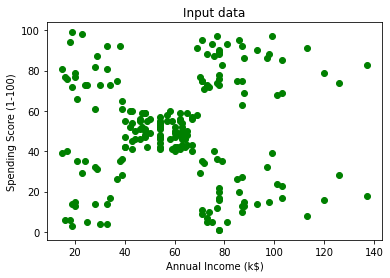

In [12]:
plt.scatter(x['Annual Income (k$)'], x['Spending Score (1-100)'], c='g')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title("Input data")
plt.show()

In [13]:
def initialize_centroids(k, data):
    n_dims = data.shape[1]
    centroid_min = data.min().min()
    centroid_max = data.max().max()
    centroids = []
    for centroid in range(k):
        centroid = np.random.uniform(centroid_min, centroid_max, n_dims)
        centroids.append(centroid)
    centroids = pd.DataFrame(centroids, columns= data.columns)
    return centroids

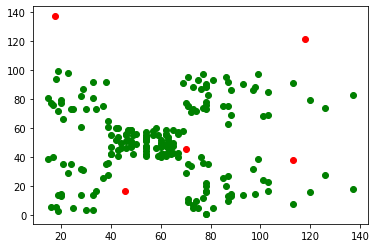

In [20]:
centroids = initialize_centroids(5, x)
plt.scatter(x['Annual Income (k$)'], x['Spending Score (1-100)'], c='g')
plt.scatter(centroids['Annual Income (k$)'], centroids['Spending Score (1-100)'], c="r")